<a href="https://colab.research.google.com/github/ta269uec/semantic-search/blob/develop/k_means_sentence_embeddings.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Installing all the packages necessary + loading the data

In [11]:
!pip install datasets transformers torch sentence-transformers --quiet

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
LIB_LOCATION = "/content/drive/MyDrive/git-repos/semantic-search/"
OUT_DATA_LOCATION = LIB_LOCATION + "data/"

In [4]:
# Clone if you do not have this.
#!git clone -b develop https://github.com/ta269uec/semantic-search.git /content/drive/MyDrive/git-repos/semantic-search/

In [14]:
import sys
sys.path.append(LIB_LOCATION)

In [15]:
from src.sentence_encoder import SentenceEncoder
from src.sst2 import get_reviews_sst2
from src.kmeans import cluster_k_means

In [16]:
pos_sentences, neg_sentences = get_reviews_sst2()

In [7]:
st = SentenceEncoder()

In [17]:
pos_embeddings, neg_embeddings = st.encode(pos_sentences), st.encode(neg_sentences)

In [26]:
import os
import pickle
file_name_pos = os.path.join(OUT_DATA_LOCATION, 'sst2_train_pos_embeddings.pkl')
file_name_neg = os.path.join(OUT_DATA_LOCATION, 'sst2_train_neg_embeddings.pkl')
with open(file_name_pos, "wb") as fd:
  pickle.dump(pos_embeddings, fd)
with open(file_name_neg, "wb") as fd:
  pickle.dump(neg_embeddings, fd)

# Build K-Means Clusters

In [18]:
def build_clusters(N, pos_sentences, pos_embeddings, neg_sentences, neg_embeddings):
  clustered_pos_sentences, clustered_pos_embeddings = cluster_k_means(corpus = pos_sentences,\
                                                            corpus_embeddings = pos_embeddings.cpu(),\
                                                            num_clusters = N)
  clustered_neg_sentences, clustered_neg_embeddings = cluster_k_means(corpus = neg_sentences,\
                                                            corpus_embeddings = neg_embeddings.cpu(),\
                                                            num_clusters = N)
  return (clustered_pos_sentences, clustered_pos_embeddings), (clustered_neg_sentences, clustered_neg_embeddings)


In [24]:
import os
import pickle
def serialize_clusters(root, ds_name, label, n_clusters, results):
  file_prefix = f"{ds_name}_{label}_{n_clusters}_"
  sentences, embeddings = results[0], results[1]
  f1, f2 = os.path.join(root, f"{file_prefix}sentences.pkl"), os.path.join(root, f"{file_prefix}embeddings.pkl")
  with open(f1, 'wb') as handle:
    pickle.dump(sentences, handle, protocol=pickle.HIGHEST_PROTOCOL)
  with open(f2, 'wb') as handle:
    pickle.dump(sentences, handle, protocol=pickle.HIGHEST_PROTOCOL)    
  return

In [25]:
root = OUT_DATA_LOCATION
for N in [10, 25, 50, 100, 250]:
  print(f"Processing cluster size {N}")
  res_pos, res_neg = build_clusters(N, pos_sentences, pos_embeddings, neg_sentences, neg_embeddings)
  serialize_clusters(root, ds_name, label="pos", n_clusters=N, results=res_pos)
  serialize_clusters(root, ds_name, label="neg", n_clusters=N, results=res_neg)
  pass

Processing cluster size 10


/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Processing cluster size 25


/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Processing cluster size 50


/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Processing cluster size 100


/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Processing cluster size 250


/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


## Sanity Check 1: Are clusters semantically similar?

In [52]:
clusters = [len(clustered_pos_embeddings[i]) for i in range(len(clustered_pos_embeddings))]

In [53]:
import torch
X = torch.stack(clustered_pos_embeddings[0])

In [10]:
import pickle
import os

with open(os.path.join(OUT_DATA_LOCATION, "sst2/sst2_train_pos_embeddings.pkl"), "rb") as fd:
  sst2_pos_embedding = pickle.load(fd)

In [12]:
np_arr = sst2_pos_embedding.detach().cpu().numpy()


In [16]:
from sklearn.decomposition import PCA


In [35]:
explained_variance = []
for n_components in range(10,384, 10):
  print(n_components)
  pca = PCA(n_components=n_components)
  pca.fit(np_arr)
  explained_variance.append((n_components, sum(pca.explained_variance_ratio_)))

10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380


In [36]:
explained_variance

[(10, 0.21812228299677372),
 (20, 0.3231392940506339),
 (30, 0.3985733911395073),
 (40, 0.4572374215349555),
 (50, 0.5073991967365146),
 (60, 0.5515003590844572),
 (70, 0.5903498043771833),
 (80, 0.6249861943069845),
 (90, 0.6564234413672239),
 (100, 0.6857273869682103),
 (110, 0.7120534700807184),
 (120, 0.7365658096969128),
 (130, 0.7592173889279366),
 (140, 0.7804337401175871),
 (150, 0.7999389206524938),
 (160, 0.8180994949070737),
 (170, 0.8353117359802127),
 (180, 0.8509843748761341),
 (190, 0.8661888987990096),
 (200, 0.8799544563516974),
 (210, 0.8932412751019001),
 (220, 0.905415331129916),
 (230, 0.9169663528446108),
 (240, 0.9277118813479319),
 (250, 0.937468129908666),
 (260, 0.9465686391340569),
 (270, 0.9551059904042631),
 (280, 0.9628767001559027),
 (290, 0.970067129121162),
 (300, 0.9763541432912461),
 (310, 0.9822975388378836),
 (320, 0.9870250515232328),
 (330, 0.990964041207917),
 (340, 0.9940156301599927),
 (350, 0.9963257601775695),
 (360, 0.9980302316544112),
 (37

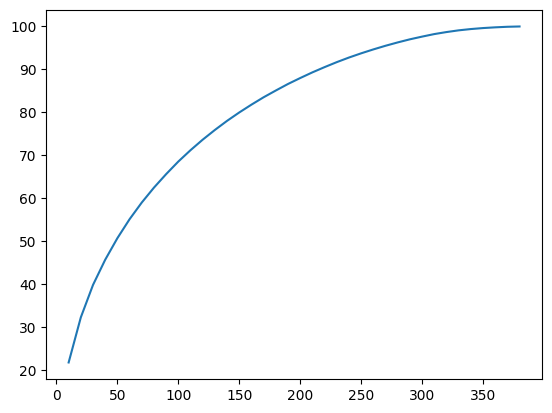

In [37]:
import numpy as np
import matplotlib.pyplot as plt

x, y = [a for a,b in explained_variance], [round(b*100,2) for a,b in explained_variance]
fig, ax = plt.subplots()
ax.plot(x, y)

In [54]:
from sentence_transformers import util

cos_scores = util.cos_sim(X, X).numpy()

In [55]:
cos_scores

array([[1.        , 0.56275344, 0.16633949, ..., 0.34173852, 0.33133203,
        0.33750123],
       [0.56275344, 1.0000001 , 0.25965416, ..., 0.31524807, 0.38929945,
        0.3176574 ],
       [0.16633949, 0.25965416, 0.9999997 , ..., 0.18074846, 0.2621564 ,
        0.18604575],
       ...,
       [0.34173855, 0.315248  , 0.18074849, ..., 1.0000002 , 0.377027  ,
        0.32030904],
       [0.33133203, 0.38929948, 0.26215637, ..., 0.37702698, 1.        ,
        0.29153726],
       [0.33750117, 0.31765735, 0.18604569, ..., 0.32030913, 0.29153726,
        0.99999976]], dtype=float32)